# LING583 Final Project
## Amazon Magazine Subscription Reviews
**Dataset source:** https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/

----------------------
#### Index
##### 1. Data Preparation
##### 2. Dummy Baseline
##### 3. VADER
######    (i) Compound Scores
######    (ii) Postive/Negative Scores Difference
##### 4. SGD Classifier
######    (i) Simple Spacy Tokenizer
######    (ii) Syntactically Augmented Classification
##### 5. Conclusions

In [68]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

In [10]:
dataset = "Magazine_Subscriptions.json"

try:
    df = pd.read_json(dataset, lines=True)

except Exception as error:
    print(type(error))
    url = f"https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/{dataset}.gz"
    df = pd.read_json(url, compression='gzip', lines=True)

df.head(10)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN
1,5,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN
2,3,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN
3,5,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN
4,5,NaN,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN
5,3,NaN,True,"06 24, 2014",A3XT9XXWXFMJ1,B00005N7P0,Jeff A Milne,This magazine was great for the times but as w...,Great While it lasted,1403568000,NaN,NaN
6,5,NaN,True,"06 1, 2014",A3ERU005ES1IHT,B00005N7P0,P. R THOMPSON,I've read Maximum PC (MPC) for many years. The...,For Both the Newbie and The Advanced PC User,1401580800,NaN,NaN
7,5,NaN,True,"05 15, 2014",AC2278WPK3EU,B00005N7P0,Earle Williams,We ordered this magazine for our grandson (the...,Great Gift,1400112000,NaN,NaN
8,4,NaN,True,"03 28, 2014",A3QRR8PSCBI07C,B00005N7P0,JJM,I have subscribed to the nook version for a fe...,Decent magazine at a good price,1395964800,NaN,NaN
9,4,NaN,True,"02 26, 2014",A5QQOOZJOVPSF,B00005N7P0,John L. Mehlmauer,"I'm old, and so is my computer. Any advice th...",Cheapskates guide,1393372800,NaN,NaN


---------------------
## Data Preparation

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89689 entries, 0 to 89688
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         89689 non-null  int64 
 1   vote            24103 non-null  object
 2   verified        89689 non-null  bool  
 3   reviewTime      89689 non-null  object
 4   reviewerID      89689 non-null  object
 5   asin            89689 non-null  object
 6   reviewerName    89687 non-null  object
 7   reviewText      89656 non-null  object
 8   summary         89670 non-null  object
 9   unixReviewTime  89689 non-null  int64 
 10  style           51398 non-null  object
 11  image           135 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 7.6+ MB
None


In [4]:
print(df["overall"].value_counts())

5    53790
4    12676
1    11029
3     6971
2     5223
Name: overall, dtype: int64


In [6]:
print(df["reviewText"].iloc[0])

for computer enthusiast, MaxPC is a welcome sight in your mailbox. i can remember for years savorying every page of "boot" (as it was called in beginning) as i was (and still am) obcessed with PC's. Anyone, from advanced users - to beginners looking for knowledge - can profit from every issue of MaxPC. the icing on the cake is the subscription that comes with a CD-ROM as it is packed with demos, utilities, and other useful apps (very helpful for those not blessed with broadband connections). Until I discovered the community of hardware enthusiast web sites, MaxPC, formerly "boot", was my only really informative source for computing news and articles. To this day, i consider my subscription to it worth more than 10 subscriptions to most other computing mags. I can't wait until they merge with DVD media and maybe end up offering more info on Divx codecs, encoding your own movies, and best bang for the buck audio and video equipment. Try a few issues (with CD)and you may get hooked...


In [12]:
len(df)

89689

In [15]:
df.isna().sum()

overall               0
vote              65586
verified              0
reviewTime            0
reviewerID            0
asin                  0
reviewerName          2
reviewText           33
summary              19
unixReviewTime        0
style             38291
image             89554
dtype: int64

**Drooping NaNs:** There are rows with no review texts which are not useful to us. Hence, dropping them. Thankfully, all rows have overall ratings.

In [16]:
df.dropna(inplace=True, subset=["reviewText"])

In [21]:
df.sort_values(by=["reviewTime"], ignore_index=True, inplace=True)
df

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,3,NaN,False,"01 1, 2002",A39V0MDFSV8U5E,B00005QDWQ,Amazon Customer,"When I ordered this magazine, my order was bas...",I was misled.,1009843200,NaN,NaN
1,4,3,False,"01 1, 2002",A1D0GLYRI50EKT,B00005QDWQ,David W. Powell,This magazine is very informative and well don...,"Great mag but,",1009843200,NaN,NaN
2,5,NaN,False,"01 1, 2002",ABMD9JHWWRLA1,B00005Q7DL,Cybertron3,What else is there to say? This mag beats all...,MA Rules!,1009843200,NaN,NaN
3,4,2,False,"01 1, 2003",A2ML4MTV1Q9HKY,B00005NIPP,Amazon Customer,"JOKES, SEX, GIRLS, CLOTHES, GADGETS...\nif you...",MAX-EM,1041379200,NaN,NaN
4,4,NaN,False,"01 1, 2003",A3176TH657RBAB,B00005OM4W,Sierra Y,"I like this magazine, I have a subscription. ...",I LIKE!,1041379200,{'Format:': ' Print Magazine'},NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
89651,5,NaN,True,"12 9, 2017",AG21LI7BOJKOL,B00005N7Q5,Amazon Customer,Great price!!,Five Stars,1512777600,{'Format:': ' Print Magazine'},NaN
89652,5,NaN,True,"12 9, 2017",A39DIG54R3H7W3,B000EGCIW8,BETH,Love this magazine! It's my monthly escape.,love it.,1512777600,{'Format:': ' Print Magazine'},NaN
89653,3,NaN,False,"12 9, 2017",A3O6GAFBSFV6E5,B005DNA3LU,Dar66,"I think the magazine is interesting, but I ord...","I think the magazine is interesting, but I ord...",1512777600,{'Format:': ' Print Magazine'},NaN
89654,5,NaN,True,"12 9, 2017",A1I15HQYUV86NB,B00007AWME,Amazon Customer,My husband loved the magazine.,Five Stars,1512777600,{'Format:': ' Print Magazine'},NaN


In [33]:
df = df[["overall", "reviewText", "summary"]]
df

,overall,reviewText,summary
0,3,"When I ordered this magazine, my order was bas...",I was misled.
1,4,This magazine is very informative and well don...,"Great mag but,"
2,5,What else is there to say? This mag beats all...,MA Rules!
3,4,"JOKES, SEX, GIRLS, CLOTHES, GADGETS...\nif you...",MAX-EM
4,4,"I like this magazine, I have a subscription. ...",I LIKE!
...,...,...,...
89651,5,Great price!!,Five Stars
89652,5,Love this magazine! It's my monthly escape.,love it.
89653,3,"I think the magazine is interesting, but I ord...","I think the magazine is interesting, but I ord..."
89654,5,My husband loved the magazine.,Five Stars


In [34]:
df["text"] = + df["summary"] + " " + df["reviewText"]
df

,overall,reviewText,summary,text
0,3,"When I ordered this magazine, my order was bas...",I was misled.,"I was misled. When I ordered this magazine, my..."
1,4,This magazine is very informative and well don...,"Great mag but,","Great mag but, This magazine is very informati..."
2,5,What else is there to say? This mag beats all...,MA Rules!,MA Rules! What else is there to say? This mag...
3,4,"JOKES, SEX, GIRLS, CLOTHES, GADGETS...\nif you...",MAX-EM,"MAX-EM JOKES, SEX, GIRLS, CLOTHES, GADGETS...\..."
4,4,"I like this magazine, I have a subscription. ...",I LIKE!,"I LIKE! I like this magazine, I have a subscri..."
...,...,...,...,...
89651,5,Great price!!,Five Stars,Five Stars Great price!!
89652,5,Love this magazine! It's my monthly escape.,love it.,love it. Love this magazine! It's my monthly ...
89653,3,"I think the magazine is interesting, but I ord...","I think the magazine is interesting, but I ord...","I think the magazine is interesting, but I ord..."
89654,5,My husband loved the magazine.,Five Stars,Five Stars My husband loved the magazine.


**Assumptions:**
1. If the overall rating is greater than or equal to 4, then the customer is positive about the subscription.
2. Else, customer is negative about the subscription, and may drop it.
3. Hence, 4 and 5 ratings are considered good sentiment and 1, 2 and 3 are considered bad sentiment.
4. We will use these to decide, if a customer is likely to churn or not.

In [35]:
sentiment = []
for i in range(len(df)):
    if df.iloc[i,0] >= 4:
        sentiment.append("good")
    else:
        sentiment.append("bad")
df["sentiment"]=sentiment
df

,overall,reviewText,summary,text,sentiment
0,3,"When I ordered this magazine, my order was bas...",I was misled.,"I was misled. When I ordered this magazine, my...",bad
1,4,This magazine is very informative and well don...,"Great mag but,","Great mag but, This magazine is very informati...",good
2,5,What else is there to say? This mag beats all...,MA Rules!,MA Rules! What else is there to say? This mag...,good
3,4,"JOKES, SEX, GIRLS, CLOTHES, GADGETS...\nif you...",MAX-EM,"MAX-EM JOKES, SEX, GIRLS, CLOTHES, GADGETS...\...",good
4,4,"I like this magazine, I have a subscription. ...",I LIKE!,"I LIKE! I like this magazine, I have a subscri...",good
...,...,...,...,...,...
89651,5,Great price!!,Five Stars,Five Stars Great price!!,good
89652,5,Love this magazine! It's my monthly escape.,love it.,love it. Love this magazine! It's my monthly ...,good
89653,3,"I think the magazine is interesting, but I ord...","I think the magazine is interesting, but I ord...","I think the magazine is interesting, but I ord...",bad
89654,5,My husband loved the magazine.,Five Stars,Five Stars My husband loved the magazine.,good


In [36]:
df.sentiment.value_counts()

good    66436
bad     23220
Name: sentiment, dtype: int64

In [38]:
df = df[["overall", "text", "sentiment"]]
df

,overall,text,sentiment
0,3,"I was misled. When I ordered this magazine, my...",bad
1,4,"Great mag but, This magazine is very informati...",good
2,5,MA Rules! What else is there to say? This mag...,good
3,4,"MAX-EM JOKES, SEX, GIRLS, CLOTHES, GADGETS...\...",good
4,4,"I LIKE! I like this magazine, I have a subscri...",good
...,...,...,...
89651,5,Five Stars Great price!!,good
89652,5,love it. Love this magazine! It's my monthly ...,good
89653,3,"I think the magazine is interesting, but I ord...",bad
89654,5,Five Stars My husband loved the magazine.,good


Now, that we have our data ready and processed as needed. We will proceed to analyze this data.

---------------------
## Dummy Baseline

In [69]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [45]:
train, test = train_test_split(
    df, test_size=0.4, stratify=df["sentiment"], random_state=619
)

In [46]:
dummy = DummyClassifier()
dummy.fit(train["text"], train["sentiment"])
dummy_pred = dummy.predict(test["text"])
print(classification_report(test["sentiment"], dummy_pred))

              precision    recall  f1-score   support

         bad       0.00      0.00      0.00      9288
        good       0.74      1.00      0.85     26575

    accuracy                           0.74     35863
   macro avg       0.37      0.50      0.43     35863
weighted avg       0.55      0.74      0.63     35863



**Observations:**
1. Our Baseline Dummy Classifier is able to predict accurately(well according to our assumptions), 74 percent of the times if the customer is retained, just by predicting all as good sentiment.
2. Let's explore, various other methods.

---------------------------
## VADER

In [48]:
import matplotlib.pyplot as plt
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vijaybhk/nltk_data...


### Compound scores

VADER "compound" scores are an aggregate measure of overall sentiment. VADER uses a predefined lexicon so there's no need for "training" data.

In [65]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(str(text))
    return score["compound"]


train["vader"] = train["text"].progress_apply(get_sentiment)
test["vader"] = test["text"].progress_apply(get_sentiment)

  0%|          | 0/53793 [00:00<?, ?it/s]

  0%|          | 0/35863 [00:00<?, ?it/s]

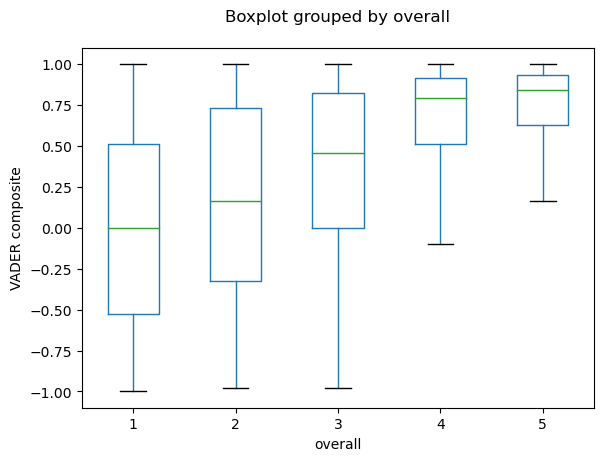

In [66]:
train.boxplot("vader", by="overall", grid=False, showfliers=False)
plt.ylabel("VADER composite")
plt.title("")
plt.show()

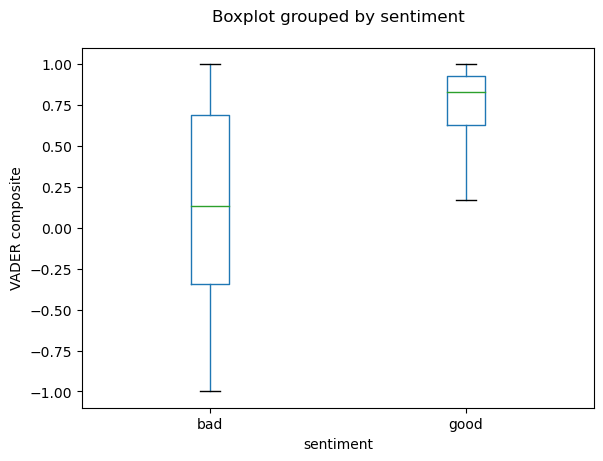

In [67]:
train.boxplot("vader", by="sentiment", grid=False, showfliers=False)
plt.ylabel("VADER composite")
plt.title("")
plt.show()

1. Vader composite are supposed to positive for positive reviews and negative for negative reviews.
2. As we compare vader composite scores to the review overall ratings and sentiments, we can observe that the variation is huge.
3. Ratings 1, 2 and 3 or bad sentiment(which is our primary target in identifying) is spread across the entire score range, and the mean is above 0, that is positive.
4. So we can say using Vader composite scores, differentiating a good and bad review is not that accurate.
5. Let's find its accuracy by getting a threshold value to differentiate good and bad in the composite scores.

In [70]:
theta = np.linspace(-1.0, 1.0, 50)
compound = [accuracy_score((train["vader"] > t), (train["sentiment"] == "good")) for t in theta]

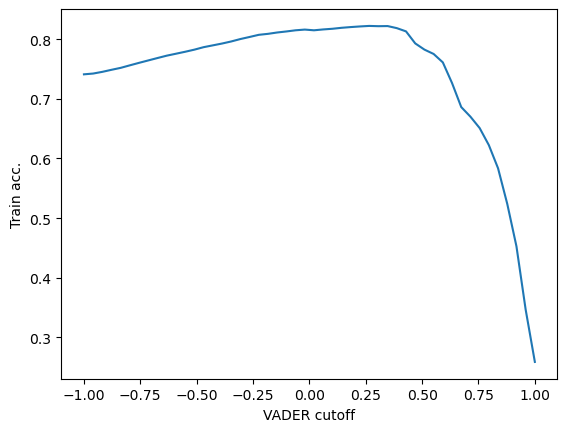

In [71]:
plt.plot(theta, compound)
plt.xlabel("VADER cutoff")
plt.ylabel("Train acc.")
plt.show()

In [74]:
thresh = theta[np.argmax(compound)]
thresh

0.26530612244897944

Peak is at 0.265 composite score, meaning if we classify anything above it as good and equal or below as bad, we get more accurate results.

In [75]:
accuracy_score((test["vader"] > thresh), (test["sentiment"] == "good"))

0.8168864846778017

In [97]:
print(classification_report((test["vader"] > thresh), (test["sentiment"] == "good")))

              precision    recall  f1-score   support

       False       0.47      0.70      0.56      6199
        True       0.93      0.83      0.88     29664

    accuracy                           0.81     35863
   macro avg       0.70      0.77      0.72     35863
weighted avg       0.85      0.81      0.83     35863



Using Vader composite scores, we are able to predict our customer sentiment correctly 81 percent of the times, which is a good metric when compared to our dummy baseline(if we considered all good).

Let's observe some errors that Vader made.
1. Consider an observation where vader gave a composite score above 0.9 which is a good sentiment as per our chosen threshold, and it's originally labeled sentiment is bad.
2. Consider another observation where vader gave a composite score of less than -0.9 which is a bad sentiment as per our chosen threshold, and it's originally labeled sentiment is good.

In [81]:
train[(train["vader"] > 0.9) & (train["sentiment"] == "bad")]["text"].iloc[0]

"Great price Great price. I don't seem to know enough to understand it. It's I'm sure it a great magazine for those whom can understand it."

In [82]:
analyzer.polarity_scores(_)

{'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'compound': 0.9393}

Looking at the words used in this review, just observing one by one seeing it out of context, one would assume it as positive, but when you put it into context, the reviewer thinks it(magazine) is not a good fit for him.
Vader fails to interpret intention.

Vader did not give a negative score to the above review, only found it neutral and positive.

In [83]:
train[(train["vader"] < -0.9) & (train["sentiment"] == "good")]["text"].iloc[1]

'Insecure Bullies Won\'t Win Will I like it? I don\'t know. Do I speak french? No. Do I think some of it might be offensive? Maybe. Is the purchase worth it? The purchase is priceless. You can\'t put a value on a free and open society. Stick it to these mental midget, violent, pathetic, cowardly human beings who are so insecure about their beliefs that they will mercilessly kill fellow human beings because they are "offended" by what they say. Show them that life is what is sacred. Stand together and rid this world of this disease.'

In [84]:
analyzer.polarity_scores(_)

{'neg': 0.294, 'neu': 0.662, 'pos': 0.044, 'compound': -0.9826}

Although the words used in this review are highly negative, reviewer is positive about the content in the magazine, but the magazine itself is strongly negative, when reviewer put forth review of it, it came through as negative to vader. Hence, Vader gave the review a low positive score, which reflected in the negative compound score.

## Positive/negative difference

An alternative to the compound score is to compare the % positive vs the % negative.
Let's take scoring as positive minus negative instead of the composite and see if this approach would give better results.

In [86]:
def get_diff(text):
    scores = analyzer.polarity_scores(str(text))
    return scores["pos"] - scores["neg"]


train["vader_diff"] = train["text"].progress_apply(get_diff)
test["vader_diff"] = test["text"].progress_apply(get_diff)

  0%|          | 0/53793 [00:00<?, ?it/s]

  0%|          | 0/35863 [00:00<?, ?it/s]

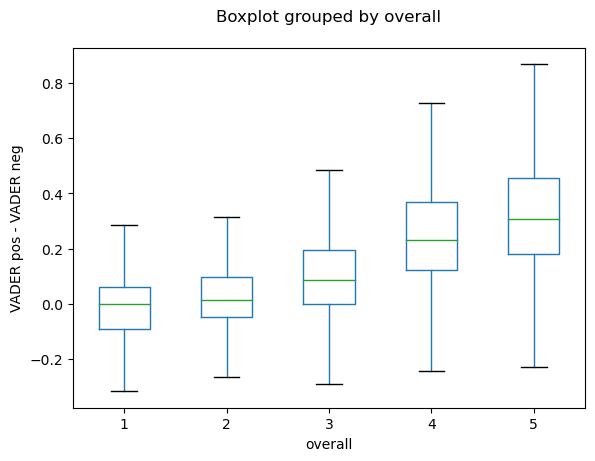

In [87]:
train.boxplot("vader_diff", by="overall", grid=False, showfliers=False)
plt.ylabel("VADER pos - VADER neg")
plt.title("")
plt.show()

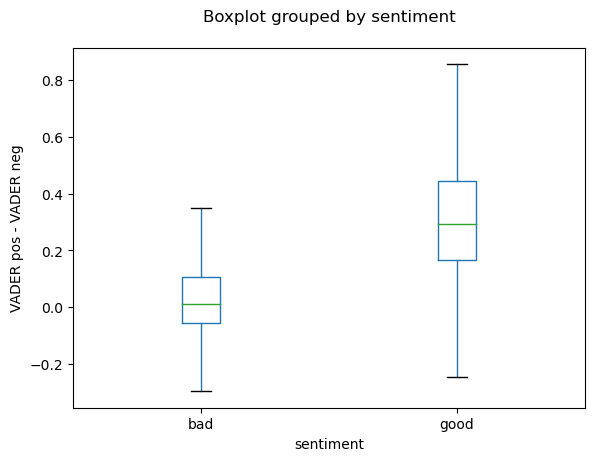

In [90]:
train.boxplot("vader_diff", by="sentiment", grid=False, showfliers=False)
plt.ylabel("VADER pos - VADER neg")
plt.title("")
plt.show()

This approach shows a better correlation with user ratings and sentiment. Let's find its accuracy by getting a threshold value to differentiate good and bad in the difference scores. so that we can compare how accurate is this approach compared to the previous one.

Text(0, 0.5, 'Train acc.')

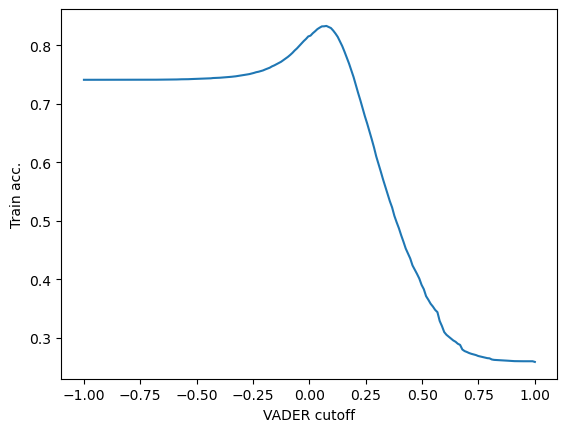

In [98]:
theta = np.linspace(-1.0, 1.0, 200)
diff = [accuracy_score((train["vader_diff"] > t), (train["sentiment"] == "good")) for t in theta]

plt.plot(theta, diff)
plt.xlabel("VADER cutoff")
plt.ylabel("Train acc.")

In [99]:
thresh = theta[np.argmax(diff)]
thresh

0.07537688442211055

In [101]:
accuracy_score((test["vader_diff"] > thresh), (test["sentiment"] == "good"))

0.8281794607255388

In [100]:
print(classification_report((test["vader_diff"] > thresh), (test["sentiment"] == "good")))

              precision    recall  f1-score   support

       False       0.66      0.67      0.67      9166
        True       0.89      0.88      0.88     26697

    accuracy                           0.83     35863
   macro avg       0.77      0.78      0.78     35863
weighted avg       0.83      0.83      0.83     35863



Let's observe some errors that Vader made.
1. Consider an observation where vader gave a difference score above 0.6 which is a good sentiment as per our chosen threshold, and it's originally labeled sentiment is bad.
2. Consider another observation where vader gave a difference score of less than -0.6 which is a bad sentiment as per our chosen threshold, and it's originally labeled sentiment is good.

In [123]:
train[(train["vader_diff"] > 0.5) & (train["sentiment"] == "bad")]["text"].iloc[0]

'One Star love it!'

In [124]:
analyzer.polarity_scores(_)

{'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.6696}

In [126]:
train[(train["vader_diff"] > 0.5) & (train["sentiment"] == "bad")]["overall"].iloc[0]

1

While the review text here says, love it, but the reviewer meant it sarcastically. Rating given to it, can support my view of the review.

In [117]:
train[(train["vader_diff"] < -0.6) & (train["sentiment"] == "good")]["text"].iloc[0]

'Five Stars no problems'

In [118]:
analyzer.polarity_scores(_)

{'neg': 0.71, 'neu': 0.29, 'pos': 0.0, 'compound': -0.5994}

In [119]:
train[(train["vader_diff"] < -0.6) & (train["sentiment"] == "good")]["overall"].iloc[0]

5

Similarly, here the reviewer found no problems and gave five stars, but vader could find no and problem words which are negative in meaning independently, which has affected its interpretation.

Although, we used our labeled data to analyze vader's performance. It does not need a training data, just give out sentiment scores. Which can be used in cases when there is no labeled data to analyze or build a better model fed with specific kind of data.

Since, we have labeled data with us from Amazon, Let's try building a classifier model, and see if we can get better results than vader.


------------------
## SGD Classifier

In a classification, the results may vary depending upon our approach of tokenization.
Let's try different tokenization methods, and see which gives better results with our classifier.

### Simple Spacy Tokenizer

In [129]:
from cytoolz import *

import spacy

In [133]:
nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(text):
    doc = nlp.tokenizer(str(text))
    return [t.norm_ for t in doc if not (t.is_space or t.is_punct or t.like_num)]

In [134]:
train["tokens1"] = train["text"].progress_apply(tokenize)
test["tokens1"] = test["text"].progress_apply(tokenize)

  0%|          | 0/53793 [00:00<?, ?it/s]

  0%|          | 0/35863 [00:00<?, ?it/s]

In [137]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

In [138]:
sgd_1 = make_pipeline(
    CountVectorizer(analyzer=identity), TfidfTransformer(), SGDClassifier()
)

In [139]:
sgd_1.fit(train["tokens1"], train["sentiment"])
pred_1 = sgd_1.predict(test["tokens1"])
print(classification_report(test["sentiment"], pred_1))

              precision    recall  f1-score   support

         bad       0.84      0.78      0.81      9288
        good       0.92      0.95      0.94     26575

    accuracy                           0.91     35863
   macro avg       0.88      0.86      0.87     35863
weighted avg       0.90      0.91      0.90     35863



In [140]:
accuracy_score(test["sentiment"], pred_1)

0.9055293756796698

In [141]:
error_1 = test[pred_1 != test["sentiment"]]

In [142]:
error_1[error_1["sentiment"] == "bad"]["text"].iloc[0]

"Watchtime ... can't keep time You have to wait 3-4 months , and even then it's out of date"

In [145]:
error_1[error_1["sentiment"] == "good"]["text"].iloc[1]

'Four Stars Received my first one, not much in it, but not sure what I really expected lol'

1. Accuracy of our classifier has exceeded both approaches in Vader.
2. First error we observed is where sentiment is bad and our classifier predicted as good.
3. Second error we observed is where sentiment is good and our classifier predicted as bad.
4. Our classifier is unable to go beyond just words.
5. So, let's try with another approach, where tokenize using multi-word embeddings, and check if that makes a difference.

### Syntactically augmented classification
The easiest way to add syntactic information to SGDClassifier is by augmenting the words in the text. That is, if we want to indicate that word is in the scope of negation we'll prefix the word with `NOT:`

In [165]:
from spacy import displacy
from spacy.tokens import DocBin

nlp2 = spacy.load("en_core_web_lg", exclude=["ner"])

In [168]:
docs = DocBin(docs=nlp2.pipe(tqdm(df['text']), n_process=4))
docs.to_disk('parsed.docbin')

  0%|          | 0/89656 [00:00<?, ?it/s]

In [169]:
docs = DocBin().from_disk("parsed.docbin")
df["doc"] = list(docs.get_docs(nlp2.vocab))

In [170]:
train, test = train_test_split(
    df, test_size=0.4, stratify=df["sentiment"], random_state=619
)

In [171]:
from spacy.tokens import Token

Token.set_extension("neg", default=False, force=True)

In [172]:
def simple_negation(doc):
    for tok in doc:
        tok._.neg = False
    for tok in doc:
        if tok.dep_ == "neg":
            tok.head._.neg = True
    return doc


def add_not(tok):
    if tok._.neg:
        return "NOT:" + tok.norm_
    else:
        return tok.norm_


def tokenize_not(negator):
    def tokenizer(doc):
        return [add_not(t) for t in negator(doc)]

    return tokenizer

In [183]:
sample = nlp2("This magazine is not perfect, also not bad entirely")
displacy.render(sample)

In [185]:
sampler = tokenize_not(simple_negation)
sampler(sample)

['this',
 'magazine',
 'NOT:is',
 'not',
 'perfect',
 ',',
 'also',
 'not',
 'NOT:bad',
 'entirely']

In [175]:
m1 = make_pipeline(
    CountVectorizer(
        preprocessor=identity,
        tokenizer=tokenize_not(simple_negation),
        token_pattern=None,
    ),
    TfidfTransformer(),
    SGDClassifier(random_state=42),
)
m1.fit(train["doc"], train["sentiment"])
m1.score(test["doc"], test["sentiment"])

0.9203636059448457

In [176]:
m1_pred = m1.predict(test["doc"])
print(classification_report(test["sentiment"], m1_pred))

              precision    recall  f1-score   support

         bad       0.87      0.81      0.84      9288
        good       0.94      0.96      0.95     26575

    accuracy                           0.92     35863
   macro avg       0.90      0.89      0.89     35863
weighted avg       0.92      0.92      0.92     35863



As our previous accuracy was already at 90 percent, Now after using negation, our accuracy bumped to 92 percent which is quite a good improvement.

In [177]:
def print_top_feats(M, k=0):
    V = M.named_steps["countvectorizer"].get_feature_names_out()
    coef = M.named_steps["sgdclassifier"].coef_[0]
    order = coef.argsort()
    for w1, w2 in zip(order[-k:][::-1], order[:k]):
        print(f"{V[w1]:20s} {coef[w1]:7.3f} | {V[w2]:20s} {coef[w2]:7.3f}")

In [178]:
print_top_feats(m1, 50)

five                   5.348 | not                   -5.425
great                  4.766 | three                 -5.062
love                   4.440 | star                  -3.636
four                   4.415 | disappointed          -3.235
best                   3.530 | two                   -2.724
excellent              2.999 | disappointing         -2.609
always                 2.644 | canceled              -2.392
easy                   2.598 | no                    -2.319
enjoy                  2.518 | boring                -2.302
good                   2.413 | poor                  -2.272
favorite               2.333 | nothing               -2.221
well                   2.162 | horrible              -2.210
happy                  2.083 | waste                 -2.204
loves                  2.060 | cancel                -2.037
awesome                1.909 | never                 -1.955
NOT:beat               1.874 | ads                   -1.928
perfect                1.822 | same     

"renewing" subscription for the magazine is a good thing, but when there is not before, and combined to renew, it is not a good thing for us. Hence, our approach to add not has worked, and is shown in NOT:renew and NOT:renewing with negative coefficients.


**Next steps:** once we've identified negated words, we'll spread the negative marker onto dependent words that come to the right of the negate word. Not all words to the right, though. Just ones that are dependents of the negated word.

In [179]:
def negify(tok):
    tok._.neg = True
    for child in tok.children:
        negify(child)


def negate_comps(doc):
    for tok in doc:
        tok._.neg = False
    for tok in doc:
        if tok.dep_ == "neg":
            tok.head._.neg = True
            for right_tok in tok.head.rights:
                if right_tok.dep_ in ["acomp", "advmod", "dobj", "prep", "xcomp"]:
                    negify(right_tok)
    return doc

In [187]:
sampler = tokenize_not(negate_comps)
sampler(sample)

['this',
 'magazine',
 'NOT:is',
 'not',
 'NOT:perfect',
 'NOT:,',
 'NOT:also',
 'NOT:not',
 'NOT:bad',
 'NOT:entirely']

In [188]:
m2 = make_pipeline(
    CountVectorizer(
        preprocessor=identity, tokenizer=tokenize_not(negate_comps), token_pattern=None
    ),
    TfidfTransformer(),
    SGDClassifier(random_state=42),
)

m2.fit(train["doc"], train["sentiment"])
m2.score(test["doc"], test["sentiment"])

0.9221481749993029

In [189]:
m2_pred = m2.predict(test["doc"])
print(classification_report(test["sentiment"], m2_pred))

              precision    recall  f1-score   support

         bad       0.87      0.82      0.85      9288
        good       0.94      0.96      0.95     26575

    accuracy                           0.92     35863
   macro avg       0.90      0.89      0.90     35863
weighted avg       0.92      0.92      0.92     35863



In [190]:
print_top_feats(m2, 50)

five                   5.324 | not                   -5.128
great                  4.725 | three                 -5.103
four                   4.536 | star                  -3.710
love                   4.395 | disappointed          -3.447
best                   3.522 | two                   -2.809
excellent              3.027 | disappointing         -2.502
easy                   2.681 | canceled              -2.497
always                 2.654 | boring                -2.372
good                   2.484 | no                    -2.331
enjoy                  2.452 | poor                  -2.239
favorite               2.240 | horrible              -2.154
well                   2.155 | waste                 -2.154
happy                  2.115 | nothing               -2.087
NOT:beat               1.997 | NOT:worth             -2.079
loves                  1.988 | cancel                -2.044
awesome                1.935 | ads                   -2.029
perfect                1.818 | same     

Not a lot of improvement, as our model was already performing better. But it's still good thing, as the rise is there atleast by 0.002

Next, we'll combine heads with their modifiers

In [191]:
def mod_tokenizer(doc):
    doc = negate_comps(doc)
    toks = [add_not(tok) for tok in doc]
    toks = toks + [
        add_not(t.head) + "_" + add_not(t) for t in doc if t.dep_ in ["amod", "advmod"]
    ]
    return toks

In [192]:
mod_tokenizer(sample)

['this',
 'magazine',
 'NOT:is',
 'not',
 'NOT:perfect',
 'NOT:,',
 'NOT:also',
 'NOT:not',
 'NOT:bad',
 'NOT:entirely',
 'NOT:bad_NOT:also',
 'NOT:is_NOT:entirely']

In [193]:
m3 = make_pipeline(
    CountVectorizer(preprocessor=identity, tokenizer=mod_tokenizer, token_pattern=None),
    TfidfTransformer(),
    SGDClassifier(),
)
m3.fit(train["doc"], train["sentiment"])
m3.score(test["doc"], test["sentiment"])

0.9236539051390013

In [194]:
m3_pred = m3.predict(test["doc"])
print(classification_report(test["sentiment"], m3_pred))

              precision    recall  f1-score   support

         bad       0.87      0.83      0.85      9288
        good       0.94      0.96      0.95     26575

    accuracy                           0.92     35863
   macro avg       0.91      0.89      0.90     35863
weighted avg       0.92      0.92      0.92     35863



In [195]:
print_top_feats(m3, 50)

five                   5.514 | three                 -5.613
four                   4.694 | not                   -5.606
great                  4.642 | star                  -4.026
love                   4.631 | disappointed          -3.411
best                   3.553 | two                   -3.049
excellent              3.047 | no                    -2.471
always                 2.722 | boring                -2.455
easy                   2.630 | canceled              -2.455
enjoy                  2.493 | disappointing         -2.307
good                   2.303 | poor                  -2.293
favorite               2.182 | nothing               -2.197
well                   2.126 | bad                   -2.189
loves                  2.047 | horrible              -2.180
happy                  2.013 | waste                 -2.138
NOT:beat               1.969 | cancel                -2.137
awesome                1.900 | ads                   -2.112
perfect                1.812 | NOT:worth

Not a lot of improvement again, a rise is a still a rise, meaning, we are on right track.
As we reached 92 percent accuracy, and room for improvement is very minimal at this stage, let's stop here and analyze where our model went wrong in predictions

In [196]:
error = test[m3_pred != test["sentiment"]]

In [200]:
error[error["sentiment"] == "bad"]["text"].iloc[1]

'Three Stars I think it is a great entertaining magazine for boys. They usually like weird but true articles.'

This is an indirect review. The review seems positive, but it is not. Reviewer sentiment is bad here, but the model predicted good according to the text. Model obviously cannot read between the lines as a human could. Reviewer meant that this magazine is not for him/her.

In [199]:
error[error["sentiment"] == "good"]["text"].iloc[1]

"Good, but could be better I'm not sure that the magazine is as good as it was many years ago.  All things change and so has Consumer Reports.  The articles seem a bit short, more information would usually be helpful.  Maybe that additional content would be available in the online version, which I haven't tried yet.  Still, the magazine is a great place to get reviews that aren't influenced by business."

The Reviewer here is positive sentiment, but what drived the model to predict bad is the author view of how magazine has changed over time.

----------------------
## Conclusions

For a magazine publisher/seller, who do not have historical labeled data or resources like Amazon, Can use our model trained on amazon review data, to predict if their customer retains or churns based on the sentiment.
Through our multiple approaches, while VADER sentiment scores do help, generating a cutoff do need some kind of labeled data or else we go blind on our threshold cut off.
Finally, Our SGD Classifier has performed extremely well in identifying the customers sentiment, using sytactically augmented classification.

**Additional Tests:**
Random Tests on our model using reviews picked from google search

In [202]:
review1 = "Not even worth the $5" + " " + "While understanding this magazine will contain ads in it, I didn't expect the large mass of ads in this! This magazine is called better home's and gardens I've subscribed to this magazine because I was hoping for garden ideas. Nothing but maybe a 2 page insert about what type of mulch to use, if that. The rest is just pictures of houses with no ideas, just look how pretty this house is. ugh. I'm happy I got this for almost nothing as I would've been so mad! Please look at it at the checkout at the grocery store and see if it's for you. They should change their title!"

In [228]:
analyzer.polarity_scores(review1)

{'neg': 0.104, 'neu': 0.762, 'pos': 0.134, 'compound': 0.6041}

In [223]:
final = pd.DataFrame({"text": [review1]})
final["tokens"] = final["text"].apply(tokenize)

In [224]:
final

,text,tokens
0,Not even worth the $5 While understanding this...,"[not, even, worth, the, $, while, understandin..."


In [225]:
sgd_1.predict(final["tokens"])

array(['bad'], dtype='<U4')

In [226]:
docs = DocBin(docs=nlp2.pipe(tqdm(final['text'])))
final["doc"] = list(docs.get_docs(nlp2.vocab))

  0%|          | 0/1 [00:00<?, ?it/s]

In [227]:
m3.predict(final["doc"])

array(['bad'], dtype='<U4')

**Result:**
1. A random bad review for the magazine "Better Homes & Gardens Magazine" is picked from internet.
2. It got a vader compound score 0.6041, which vader thinks it is positive mostly.
3. But our simple sgd model and final sgd model both predicted, the review is bad.
4. We have predicted the customer would churn, which we could not have with a simple sentiment score.
